In [2]:
from collections import Counter
from math import log, exp
import re
import os
import sys
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs

In [3]:
# TODO: In your final submission, set `ALPHA`
#       to the value you think will be optimal for predicting on
#       unseen data
# Keep this as a package global variable
ALPHA = 1.0
# End TODO

In [4]:
class IMDBText:
    """Class to represent text, exposing generator function for words
    """
    def __init__(self, idnum, text):
        self.text = text
        self.idnum = idnum

    def get_words(self):
        # Preprocess text
        cleaned = bs(self.text, features="html.parser").text
        for word in cleaned.strip().split():
            word = re.sub(r"^\W+", "", word)
            word = re.sub(r"\W+$", "", word)
            if word:
                yield word


In [4]:
class IMDBReader:
    """Utility class for reading IMDB data
    """
    def __init__(self, data_dir):
        self.data_dir = data_dir
        dir_contents = os.listdir(data_dir)
        assert "pos" in dir_contents and "neg" in dir_contents, \
            "Could not find IMDB data in {}".format(data_dir)


    def get_texts(self, subset):
        """Generator function over texts in subset ('pos' or 'neg') of data
        """
        assert subset in ["pos", "neg"], \
            "Only data subsets 'pos' or 'neg' may be selected"
        for textfile in os.listdir(os.path.join(self.data_dir, subset)):
            if textfile[-4:] == ".txt":
                with open(os.path.join(self.data_dir, subset, textfile),
                          encoding="utf-8") as f:
                    yield IMDBText(textfile[:-4], f.read())

In [5]:
class NaiveBayes:
    """Naive Bayes text categorization model
    """

    def __init__(self, data):
        self.train(data)

    def train(self, data):
        """Train model by collecting counts from training corpus
        """

        # Counts of words in positive-/negative-class texts
        # w_count[w][y=pos]
        self.count_positive = Counter()
        # w_count[w][y=neg]
        self.count_negative = Counter()

        # Total number of reviews for each category
        # d_count[y=pos]
        self.num_positive_reviews = 0
        # d_count[y=neg]
        self.num_negative_reviews = 0

        # Total number of words in positive/negative reviews
        # w_count[y=pos]
        self.total_positive_words = 0
        # w_count[y=neg]
        self.total_negative_words = 0

        # Class priors (logprobs)
        # log(P(y=pos))
        self.p_positive = 0.0
        # log(P(y=neg))
        self.p_negative = 0.0

        # TODO: Iterate through texts and collect count statistics initialized above
        #       `self.count_<positive/negative>`
        #       `self.num_<positive/negative>_reviews`
        #       `self.total_<positive/negative>_words`
        for i, text in enumerate(data.get_texts("pos")):
            #
            self.num_positive_reviews += 1;
            for i, word in enumerate(text.get_words()):
                self.count_positive.update([word]);
            #
            if i % 100 == 0:
                sys.stdout.write(".")

        self.total_positive_words = sum(self.count_positive.values());
        print();

        for i, text in enumerate(data.get_texts("neg")):
            #
            self.num_negative_reviews += 1;
            for i, word in enumerate(text.get_words()):
                self.count_negative.update([word]);
            #
            if i % 100 == 0:
                sys.stdout.write(".");
        
        self.total_negative_words = sum(self.count_negative.values());
        print()
        # End TODO

        # Calculate derived statistics
        self.vocab = set(list(self.count_negative.keys())
                         + list(self.count_positive.keys()))
        self.p_positive = log(float(self.num_positive_reviews)) \
            - log(float(self.num_positive_reviews + self.num_negative_reviews))
        self.p_negative = log(float(self.num_negative_reviews)) \
            - log(float(self.num_positive_reviews + self.num_negative_reviews))

    def predict(self, data, alpha=1.0):
        """For each text
           - append the text id (file basename) to `text_ids`
           - append the predicted label (1.0 or -1.0) to `pred_labels`
           - append the correct (gold) label (1.0 or -1.0) to `gold_labels`
           - append the probability of the positive (1.0) class to `pred_probs`
        """
        text_ids = []
        pred_labels = []
        pred_probs = []
        gold_labels = []

        for classval in ["pos", "neg"]:
            for text in data.get_texts(classval):
                text_ids.append(text.idnum)
                if classval == "pos":
                    gold_labels.append(1.0)
                else:
                    gold_labels.append(-1.0)
                if len(text_ids) % 100 == 0:
                    sys.stdout.write(".")

                # TODO: Implement naive Bayes probability estimation to calculate class probabilities
                #       and predicted labels for each text in the test set.
                #
                #       Work using logprobs instead of probabilities in order to avoid numerical underflow.
                #       Remember that the model treats multiple occurrences of the same word within a text
                #       as independent events
                #words = [];
                sum_positive = 0;
                sum_negative = 0;
                for word in text.get_words():
                    #if word not in words:
                        #words.append(word);
                        # log(P(Pos|X))
                        sum_positive += log(self.count_positive[word] + alpha) - log(self.total_positive_words+alpha*len(self.vocab));
                        # log(P(Neg|X))
                        sum_negative += log(self.count_negative[word] + alpha) - log(self.total_negative_words+alpha*len(self.vocab));

                sum_positive += self.p_positive;
                sum_negative += self.p_negative;
                # End TODO

                # Get P(Y|X) by normalizing across log(P(Y,X)) for both values of Y
                # 1) Get K = log(P(Pos|X) + P(Neg|X))
                normalization_factor = self.log_sum(sum_positive, sum_negative)
                # 2) Calculate P(Pos|X) = e^(log(P(Pos,X)) - K)
                predicted_prob_positive = exp(sum_positive - normalization_factor)
                # 3) Get P(Neg|X) = P(Neg|X) = e^(log(P(Neg,X)) - K)
                predicted_prob_negative = 1.0 - predicted_prob_positive

                pred_probs.append(predicted_prob_positive)
                if predicted_prob_positive > predicted_prob_negative:
                    pred_labels.append(1.0)
                else:
                    pred_labels.append(-1.0)
            print()

        return text_ids, gold_labels, pred_labels, pred_probs

    def log_sum(self, logx, logy):
        """Utility function to compute $log(exp(logx) + exp(logy))$
        while avoiding numerical issues
        """
        m = max(logx, logy)
        return m + log(exp(logx - m) + exp(logy - m))


In [6]:
# 0 - Define datadirs of data
TRAIN_DATA_DIR = "hw3_data/train"
TEST_DATA_DIR = "hw3_data/test"

In [7]:
# 1 - Compute parameters for Naive Bayes
print("Computing parameters")
NB = NaiveBayes(IMDBReader(TRAIN_DATA_DIR))

Computing parameters
........................................................................................................
.........................................................................................


In [8]:
# 2 - Make predictions
print("Predicting on test set")
TEST_IDS, GOLD_LABELS, PRED_LABELS, PRED_PROBS = NB.predict(IMDBReader(TEST_DATA_DIR), alpha=ALPHA)

Predicting on test set
.....................................................................
.....................................................................


In [8]:
def evaluate_predictions(pred_labels, true_labels):
    """
    Function for obtaining the accuracy of our predictions
    Params:
        - pred_labels: predicted labels by our model.
        - true_labels: true labels of the texts.
    Returns:
        A float representing the accuracy of the predictions made.
    """
    return np.sum(np.equal(pred_labels, true_labels)) / float(len(true_labels))

In [10]:
# 3 - Evaluate Results and obtain accuracy
print("Evaluating")
ACCURACY = evaluate_predictions(PRED_LABELS, GOLD_LABELS)
print("Test accuracy: {:.2f}%".format(100 * ACCURACY))

Evaluating
Test accuracy: 82.43%


In [9]:
def evaluate_case(alpha=1.0):
    print("Predicting on test set for alpha=%f" % alpha)
    TEST_IDS, GOLD_LABELS, PRED_LABELS, PRED_PROBS = NB.predict(IMDBReader(TEST_DATA_DIR), alpha=alpha)
    print("Evaluating")
    ACCURACY = evaluate_predictions(PRED_LABELS, GOLD_LABELS)
    print("Test accuracy: {:.2f}%".format(100 * ACCURACY))
    return (alpha, ACCURACY)

In [10]:
%%time
results = {}
for i in range(1,10):
    alpha, acc = evaluate_case(i);
    results[alpha] = acc

Predicting on test set for alpha=1.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 82.43%
Predicting on test set for alpha=2.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 82.58%
Predicting on test set for alpha=3.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 82.78%
Predicting on test set for alpha=4.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 82.85%
Predicting on test set for alpha=5.000000
.....................................................................
............................

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(results):
    """
    Plot tthe accuracies obtain for the diferent values of alpha.
    Params:
        - results: dict containing the values of alpha as keys and accuracies as values.
    """
    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), 'bo-')
    plt.xlabel('alpha')
    plt.ylabel('Accuracy')
    plt.show()

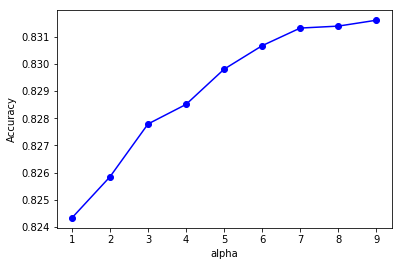

In [12]:
plot_results(results)

Predicting on test set for alpha=1.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 82.43%
Predicting on test set for alpha=11.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.29%
Predicting on test set for alpha=21.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.30%
Predicting on test set for alpha=31.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.24%
Predicting on test set for alpha=41.000000
.....................................................................
........................

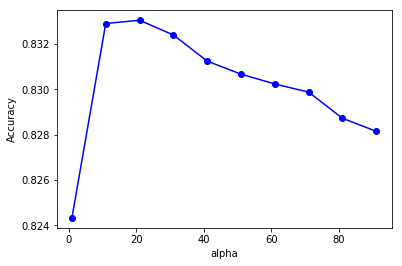

CPU times: user 6min 13s, sys: 6.01 s, total: 6min 19s
Wall time: 6min 20s


In [13]:
%%time
results_1_100 = {}
for i in range(1,100,10):
    alpha, acc = evaluate_case(i);
    results_1_100[alpha] = acc
plot_results(results_1_100)

In [14]:
%%time
results_1_20000 = {}
for i in range(1,20000,1000):
    alpha, acc = evaluate_case(i);
    results_1_20000[alpha] = acc
plot_results(results_1_20000)

Predicting on test set for alpha=1.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 82.43%
Predicting on test set for alpha=1001.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 78.12%
Predicting on test set for alpha=2001.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 75.45%
Predicting on test set for alpha=3001.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 73.37%
Predicting on test set for alpha=4001.000000
.....................................................................
................

KeyboardInterrupt: 

Predicting on test set for alpha=50.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.07%
Predicting on test set for alpha=51.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.07%
Predicting on test set for alpha=52.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.08%
Predicting on test set for alpha=53.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.04%
Predicting on test set for alpha=54.000000
.....................................................................
.......................

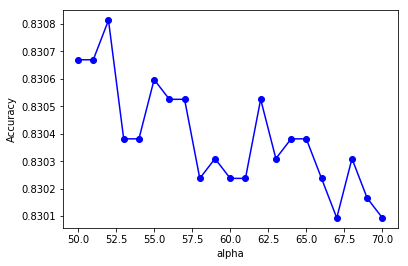

CPU times: user 18min 47s, sys: 25.6 s, total: 19min 12s
Wall time: 8h 12min 12s


In [15]:
%%time
results_51_71 = {}
for i in range(50,71,1):
    alpha, acc = evaluate_case(i);
    results_51_71[alpha] = acc
plot_results(results_51_71)

Predicting on test set for alpha=48.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.02%
Predicting on test set for alpha=49.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.05%
Predicting on test set for alpha=50.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.07%
Predicting on test set for alpha=51.000000
.....................................................................
.....................................................................
Evaluating
Test accuracy: 83.07%
Predicting on test set for alpha=52.000000
.....................................................................
.......................

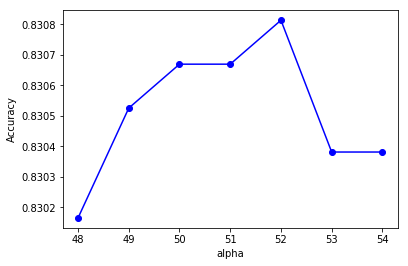

CPU times: user 5min 40s, sys: 5.39 s, total: 5min 45s
Wall time: 5min 47s


In [16]:
%%time
results_48_55 = {}
for i in range(48,55,1):
    alpha, acc = evaluate_case(i)
    results_48_55[alpha] = acc
plot_results(results_48_55)